In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, Add, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2024-05-28 07:22:32.034641: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 07:22:36.262508: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-05-28 07:22:36.264238: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [3]:
# Load data
xtrain_data = pd.read_csv('XTrain.csv')
ytrain_data = pd.read_csv('YTrain.csv')
engine_data = np.array(pd.read_csv('Engine.csv'))
xtest_data = pd.read_csv('XTest.csv')
ytest_data  = pd.read_csv('YTest.csv')
engine_test_data = np.array(pd.read_csv('Engine_Test.csv'))

In [4]:
# Data saturation function
def saturation_RUL(inp_df, th):
    temp_data = np.array(inp_df)
    temp_data[temp_data > th] = th
    return temp_data

threshold = 130
ytrain_data['Remaining Cycles'] = saturation_RUL(ytrain_data['Remaining Cycles'], threshold)
ytest_data['Remaining Cycles'] = saturation_RUL(ytest_data['Remaining Cycles'], threshold)



In [5]:
# Training data transformation for LSTM
def Feature_Transform(xdata, engdata, window=30):
    n_samp = []
    engines = np.unique(engdata)
    for j in engines:
        local_df = xdata[engdata == j]
        num_samples = len(local_df) - window
        input_list = [np.expand_dims(np.atleast_2d(local_df.iloc[i:window+i,:]), axis=0) for i in range(num_samples)]
        if j == engines[0]:
            input_mat = np.concatenate(input_list, axis=0)
        else:
            input_mat = np.concatenate([input_mat, np.concatenate(input_list, axis=0)], axis=0)
        n_samp.append(num_samples)
    return input_mat, n_samp            


In [6]:
# RUL transformation for LSTM
def RUL_Transform(ydata, engdata, window=30):
    engines = np.unique(engdata)
    for j in engines:
        local_df = ydata[engdata == j]
        num_samples = len(local_df) - window
        input_list = [np.expand_dims(local_df.iloc[window+i], axis=0) for i in range(num_samples)]
        if j == engines[0]:
            input_mat = np.concatenate(input_list, axis=0)
        else:
            input_mat = np.concatenate([input_mat, np.concatenate(input_list, axis=0)], axis=0)
    return input_mat.flatten()

window = 30
xtrain, temp = Feature_Transform(xtrain_data.drop('Cycles', axis=1), engine_data, window)
ytrain = RUL_Transform(ytrain_data, engine_data, window)
xtest, n_samp = Feature_Transform(xtest_data.drop('Cycles', axis=1), engine_test_data, window)
ytest = RUL_Transform(ytest_data, engine_test_data, window)

x_train, x_val, y_train, y_val = train_test_split(xtrain, ytrain, test_size=0.2, random_state=83)
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)


(14104, 30, 12) (3527, 30, 12) (14104,) (3527,)


In [7]:
features = xtrain.shape[2]

In [8]:
# Define Transformer block
def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = Add()([x, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)
    
    y = Dense(ff_dim, activation="relu")(x)
    y = Dropout(dropout)(y)
    y = Dense(inputs.shape[-1])(y)
    y = Add()([y, x])
    y = LayerNormalization(epsilon=1e-6)(y)
    return y

In [9]:
# Build the Transformer model
input_layer = Input(shape=(window, features))
transformer = transformer_block(input_layer, head_size=64, num_heads=4, ff_dim=64, dropout=0.1)
transformer = transformer_block(transformer, head_size=64, num_heads=4, ff_dim=64, dropout=0.1)
transformer = GlobalAveragePooling1D()(transformer)
transformer = Dropout(0.1)(transformer)
dense = Dense(96, activation='relu')(transformer)
dense = Dense(128, activation='relu')(dense)
output_layer = Dense(1)(dense)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

2024-05-28 07:22:45.567718: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-05-28 07:22:45.567766: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-05-28 07:22:45.567795: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (instance-20240527-122318): /proc/driver/nvidia/version does not exist
2024-05-28 07:22:45.569036: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow 

In [10]:
# Fit the model
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), batch_size=32, verbose=2)


Epoch 1/10
441/441 - 18s - loss: 1307.8728 - val_loss: 206.0178 - 18s/epoch - 41ms/step
Epoch 2/10
441/441 - 13s - loss: 249.5858 - val_loss: 228.7640 - 13s/epoch - 29ms/step
Epoch 3/10
441/441 - 13s - loss: 226.3683 - val_loss: 194.0733 - 13s/epoch - 29ms/step
Epoch 4/10
441/441 - 13s - loss: 209.1262 - val_loss: 238.9923 - 13s/epoch - 29ms/step
Epoch 5/10
441/441 - 13s - loss: 189.7878 - val_loss: 392.7069 - 13s/epoch - 29ms/step
Epoch 6/10
441/441 - 13s - loss: 189.5023 - val_loss: 238.3389 - 13s/epoch - 30ms/step
Epoch 7/10
441/441 - 13s - loss: 186.5713 - val_loss: 241.8346 - 13s/epoch - 29ms/step
Epoch 8/10
441/441 - 13s - loss: 173.8268 - val_loss: 314.0082 - 13s/epoch - 29ms/step
Epoch 9/10
441/441 - 13s - loss: 165.7660 - val_loss: 191.3624 - 13s/epoch - 29ms/step
Epoch 10/10
441/441 - 13s - loss: 159.8842 - val_loss: 247.0230 - 13s/epoch - 29ms/step


In [16]:
# Make predictions
ypred = model.predict(xtest)

316/316 [==============================] - 4s 12ms/step


In [17]:
# Evaluate model performance
print('RMSE: ' + str(np.sqrt(mean_squared_error(ytest, ypred))))
print('R2: ' + str(r2_score(ytest, ypred)))

RMSE: 19.0942721352651
R2: 0.6336626749230634


In [18]:
# Post-process predictions and actual values for plotting and evaluation
wind = 1
n_samp = np.array(n_samp)
samp = {'n_samp': n_samp, 'cumulative': n_samp.cumsum(), 'windowed': n_samp.cumsum()-wind}
samp = pd.DataFrame(samp)

ypred = ypred.flatten()
ytest_trunc = []
ypred_trunc = []
for i in range(len(samp)):
    if samp.iloc[i, 2] > 0:
        ytest_trunc.append(ytest[samp.iloc[i, 2]:samp.iloc[i, 1]])
        ypred_trunc.append(ypred[samp.iloc[i, 2]:samp.iloc[i, 1]])
ypred_truc = np.concatenate(ypred_trunc)
ytest_truc = np.concatenate(ytest_trunc)


In [19]:
# Evaluate truncated predictions
print('RMSE: ' + str(np.sqrt(mean_squared_error(ytest_truc, ypred_truc))))
print('R2: ' + str(r2_score(ytest_truc, ypred_truc)))

RMSE: 15.421508355941613
R2: 0.8565643339488669


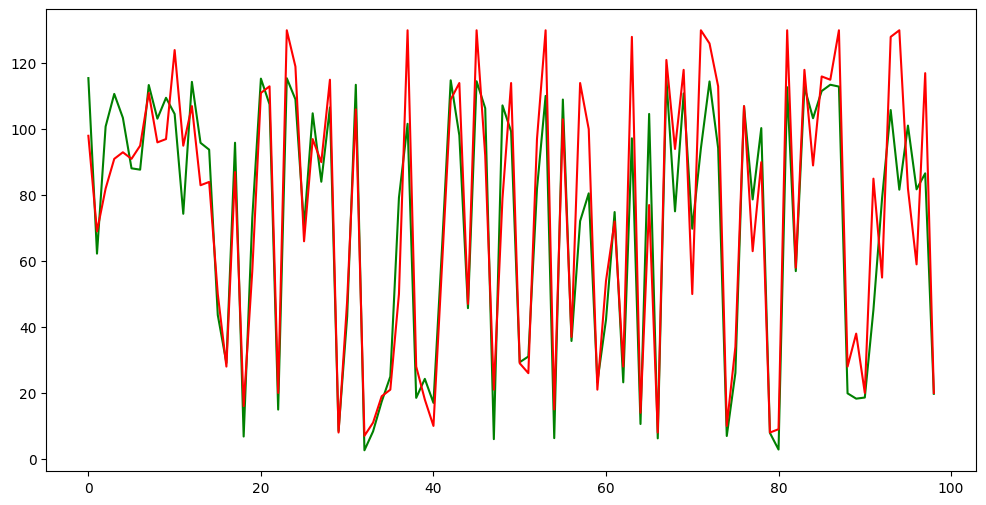

In [20]:
# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(ypred_truc, color='g')
plt.plot(ytest_truc, color='r')
plt.show()

In [21]:
ytrain_data

,Remaining Cycles
0,130
1,130
2,130
3,130
4,130
...,...
20626,4
20627,3
20628,2
20629,1


<BarContainer object of 99 artists>

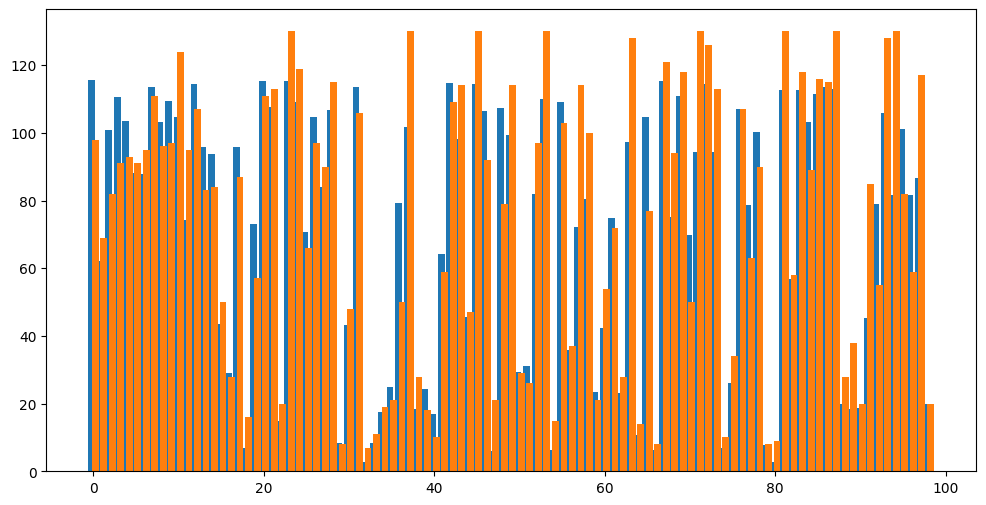

In [22]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(ytest_truc)) 
  
plt.bar(X_axis - 0.2, ypred_truc, label = 'Girls') 
plt.bar(X_axis + 0.2, ytest_truc,label = 'Boys') 
  
#plt.xticks(X_axis, X) 